In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from utilsCPD import *
import matplotlib.pyplot as plt
from SWCPD import BaseDetector as SWDCP

In [98]:
#detection_delay(set(detector.change_points['loc']),set(GroundTruth))
def detection_delay(gt, pred):
    """Compute detection delay for each predicted CP.
    
    Args:
        T (set): Ground truth CPs (annotations).
        X (set): Predicted CPs.

    Returns:
        delays (dict): {prediction: detection delay}
        avg_delay (float): Mean detection delay
    """
    T = set(gt)
    X = set(pred)
    delays = {}
    for x in X:
        if T:  # Ensure T is not empty
            closest_t = min(T, key=lambda t: abs(x - t))  # Find closest annotation
            delays[x] = abs(x - closest_t)  # Compute delay
    
    avg_delay = np.mean(list(delays.values())) if delays else 0  # Mean delay
    return delays, avg_delay


def f_measure(annotations, predictions, margin=5, alpha=0.5, return_PR=False):
    """Compute the F-measure based on human annotations.

    annotations : dict from user_id to iterable of CP locations
    predictions : iterable of predicted CP locations
    alpha : value for the F-measure, alpha=0.5 gives the F1-measure
    return_PR : whether to return precision and recall too

    Remember that all CP locations are 0-based!

    >>> f_measure({1: [10, 20], 2: [11, 20], 3: [10], 4: [0, 5]}, [10, 20])
    1.0
    >>> f_measure({1: [], 2: [10], 3: [50]}, [10])
    0.9090909090909091
    >>> f_measure({1: [], 2: [10], 3: [50]}, [])
    0.8
    """
    # ensure 0 is in all the sets
    Tks = {k + 1: set(annotations[uid]) for k, uid in enumerate(annotations)}
    for Tk in Tks.values():
        Tk.add(0)

    X = set(predictions)
    X.add(0)

    Tstar = set()
    for Tk in Tks.values():
        for tau in Tk:
            Tstar.add(tau)

    K = len(Tks)

    P = len(true_positives(Tstar, X, margin=margin)) / len(X)

    TPk = {k: true_positives(Tks[k], X, margin=margin) for k in Tks}
    R = 1 / K * sum(len(TPk[k]) / len(Tks[k]) for k in Tks)

    TP = false_positives(Tstar,X,margin=margin)
    F = P * R / (alpha * R + (1 - alpha) * P)
    if return_PR:
        return F, P, R
    return F, auc([0,R,1.0],[1.0,P,0]),len(false_positives(Tstar,X,margin=margin))



def true_positives(T, X, margin=5):
    """Compute true positives without double counting

    >>> true_positives({1, 10, 20, 23}, {3, 8, 20})
    {1, 10, 20}
    >>> true_positives({1, 10, 20, 23}, {1, 3, 8, 20})
    {1, 10, 20}
    >>> true_positives({1, 10, 20, 23}, {1, 3, 5, 8, 20})
    {1, 10, 20}
    >>> true_positives(set(), {1, 2, 3})
    set()
    >>> true_positives({1, 2, 3}, set())
    set()
    """
    # make a copy so we don't affect the caller
    X = set(list(X))
    TP = set()
    for tau in T:
        close = [(abs(tau - x), x) for x in X if abs(tau - x) <= margin]
        close.sort()
        if not close:
            continue
        dist, xstar = close[0]
        TP.add(tau)
        X.remove(xstar)
    return TP

# def false_positives(T, X, margin=5):
#     """Returns a set of false positives (incorrectly predicted CPs)."""
#     TP = true_positives(T, X, margin)
#     return X - TP  # FP = All Predictions - True Positives
def false_positives(T, X, margin=5):
    """Compute false positives (predictions that don't match any true CPs within margin)."""
    FP = set()
    for x in X:
        if not any(abs(x - t) <= margin for t in T):  # No match within margin
            FP.add(x)
    return FP

#### Add Grid Search for reviewer as well, 

### Add metrics False change rate, Detection delay, Error rate, detection accuracy

[[1.57454012 0.2        0.2        1.93199394 0.2        2.15071431
  0.2        0.2        0.2        0.2        0.2        0.2
  0.2        0.2        0.2        0.2        0.2        0.2
  0.2        0.2       ]
 [3.3731986  0.2        0.2        3.28798846 0.2        3.50673295
  0.2        0.2        0.2        0.2        0.2        0.2
  0.2        0.2        0.2        0.2        0.2        0.2
  0.2        0.2       ]]


<Axes: >

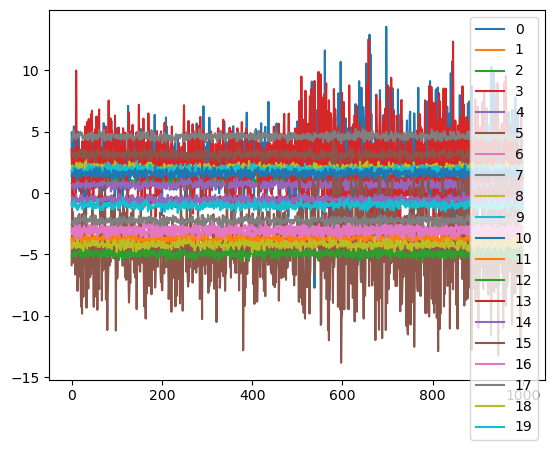

In [46]:
import numpy as np

def make_dynamic_blobs_var(n_samples, base_center, n_clusters, varying_features, 
                           base_cluster_std=1.0, std_variation_range=(0.5, 2.0), 
                           random_state=None):
    """
    Generate synthetic data where the variance of certain features varies across clusters.
    
    Parameters:
        n_samples: int
            Total number of samples.
        base_center: array-like
            The center of the first cluster. Shape: (n_features,).
        n_clusters: int
            Number of clusters to generate.
        varying_features: list of int
            Indices of features where variance should change across clusters.
        base_cluster_std: float
            Base standard deviation of clusters.
        std_variation_range: tuple
            Range (min, max) for random uniform scaling of the base standard deviation.
        random_state: int or None
            Random seed for reproducibility.
    
    Returns:
        X: ndarray of shape (n_samples, n_features)
            The generated samples.
        y: ndarray of shape (n_samples,)
            The integer labels for cluster membership.
        cluster_stds: ndarray of shape (n_clusters, n_features)
            The standard deviations used for each cluster.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n_features = len(base_center)
    samples_per_cluster = n_samples // n_clusters
    remainder = n_samples % n_clusters

    # Keep the same center for all clusters
    centers = np.tile(base_center, (n_clusters, 1))

    # Generate different standard deviations per cluster
    cluster_stds = np.full((n_clusters, n_features), base_cluster_std, dtype=float)
    
    for cluster_idx in range(n_clusters):
        for feature in varying_features:
            # Randomly scale the standard deviation for this cluster and feature
            cluster_stds[cluster_idx, feature] += np.random.uniform(*std_variation_range)#*np.random.uniform(*std_variation_range)
            if cluster_idx>0:
                cluster_stds[cluster_idx, feature] +=cluster_stds[cluster_idx-1,feature]
    
    # Generate points for each cluster
    X = []
    y = []
    for cluster_idx in range(n_clusters):
        cluster_size = samples_per_cluster + (1 if cluster_idx < remainder else 0)
        cluster_points = np.random.normal(
            loc=centers[cluster_idx],  # Keep the center fixed
            scale=cluster_stds[cluster_idx],  # Use varying standard deviation
            size=(cluster_size, n_features)
        )
        X.append(cluster_points)
        y.extend([cluster_idx] * cluster_size)
    
    X = np.vstack(X)
    y = np.array(y)
    
    return X.astype(np.float32), y, cluster_stds




base_center = list(np.random.uniform(-5,5,20))  # 2D example
n_clusters = 2
n_samples = 1000
varying_features = [0,5,3]  # Only vary the variance of the second feature
base_cluster_std = 0.2
std_variation_range = (1.0, 2.0)

X, y, cluster_stds = make_dynamic_blobs_var(n_samples, base_center, n_clusters, 
                                            varying_features, base_cluster_std, 
                                            std_variation_range, random_state=42)
print(cluster_stds)
fig, ax = plt.subplots()
pd.DataFrame(X).plot(ax=ax,legend=True)

In [89]:
METRICS_SWD = {}
for id,i in enumerate(range(1)):
    print(id)
    METRICS_SWD[id]  = {}
    df, GroundTruth = X, np.where(np.diff(y)!=0)[0]+1
    print(GroundTruth)
    #100-100
    #50-50 for ExpPLot 
    detector = SWDCP(data=df,window_length=50,max_history=50,significance=0.01)
    print(detector.device)
    detector.process_dataloader(p=4,n_theta=1000,explanations=False,exp_param={'num_features_to_remove':3,'max_parameter':True,"q":0.95})
    METRICS_SWD[id]['F1'] =f_measure({'0':GroundTruth},detector.change_points['loc'],margin=20)
    METRICS_SWD[id]['Covering'] = covering({'0':GroundTruth},detector.change_points['loc'],n_obs=df.shape[0])
    print(METRICS_SWD[id])

0
[ 500 1000]
cpu


 68%|██████▊   | 984/1451 [00:07<00:03, 127.96it/s]

Change detected at: 1014 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 140.47it/s]

{'F1': (0.8, 0.8333333333333333, 0, 7.0), 'Covering': 0.6527310979618672}


In [91]:
base_center = list(np.random.uniform(-5,5,50))#,0,0,0,0]  # Base center for the first cluster
base_cluster_std = 0.2
std_variation_range = (1.0, 2.0)

In [100]:
random_states = [2020,2021,2022,2023,2024]#,2021,2022,2023,2024,2025]
n_clusters = 3
n_samples = 1500
varying_features = [0,5,3,10,15,20]

SIGMA = [(0.5,1.0),(0.7,1.2),(1.2,1.7)]

METRICS = []
#METRICS[rs] = {}
RUN_STATS = {}
for sigma in SIGMA:
    RUN_STATS[str(sigma)] = {'F1 & AUC & FP':[],'Covering':[],'DD':[]}
    for rs in random_states:
        print(rs,sigma)
        #RUN_STATS[sigma] = {}
        X, y, centers = make_dynamic_blobs_var(
            n_samples=n_samples, 
            base_center=base_center, 
            n_clusters=n_clusters, 
            varying_features=varying_features, 
            base_cluster_std=base_cluster_std,
            std_variation_range=sigma,
            random_state=rs
        )
        df, GroundTruth = X, np.where(np.diff(y)!=0)[0]+1
        print(GroundTruth)
        detector = SWDCP(data=df,window_length=50,max_history=50,significance=0.01)
        print(detector.device)
        detector.process_dataloader(p=4,n_theta=1000,explanations=False)
        TMP = {}
        for margin in [5,10,20]:
            TMP[str(margin)] = f_measure({'0':GroundTruth},detector.change_points['loc'],margin=margin)
        RUN_STATS[str(sigma)]['F1 & AUC & FP'].append(TMP)
        RUN_STATS[str(sigma)]['Covering'].append(covering({'0':GroundTruth},detector.change_points['loc'],n_obs=df.shape[0]))
        RUN_STATS[str(sigma)]['DD'].append(detection_delay(GroundTruth,detector.change_points['loc'])[1])

    
RUN_STATS


2020 (0.5, 1.0)
[ 500 1000]
cpu


 35%|███▍      | 507/1451 [00:02<00:04, 191.87it/s]

Change detected at: 523 
Initiate new segment


100%|██████████| 1451/1451 [00:07<00:00, 191.82it/s]


2021 (0.5, 1.0)
[ 500 1000]
cpu


 33%|███▎      | 479/1451 [00:02<00:05, 184.75it/s]

Change detected at: 505 
Initiate new segment


 69%|██████▊   | 994/1451 [00:05<00:02, 190.90it/s]

Change detected at: 1010 
Initiate new segment


100%|██████████| 1451/1451 [00:07<00:00, 189.43it/s]


2022 (0.5, 1.0)
[ 500 1000]
cpu


 34%|███▍      | 490/1451 [00:02<00:05, 191.02it/s]

Change detected at: 506 
Initiate new segment


 69%|██████▊   | 997/1451 [00:05<00:02, 197.18it/s]

Change detected at: 1023 
Initiate new segment
Change detected at: 1030 
Initiate new segment


100%|██████████| 1451/1451 [00:07<00:00, 193.89it/s]


2023 (0.5, 1.0)
[ 500 1000]
cpu


 35%|███▍      | 501/1451 [00:02<00:04, 195.48it/s]

Change detected at: 523 
Initiate new segment
Change detected at: 540 
Initiate new segment


100%|██████████| 1451/1451 [00:07<00:00, 196.77it/s]


2024 (0.5, 1.0)
[ 500 1000]
cpu


 33%|███▎      | 481/1451 [00:02<00:05, 191.36it/s]

Change detected at: 508 
Initiate new segment
Change detected at: 510 
Initiate new segment


100%|██████████| 1451/1451 [00:07<00:00, 196.36it/s]


2020 (0.7, 1.2)
[ 500 1000]
cpu


 34%|███▍      | 500/1451 [00:02<00:04, 192.80it/s]

Change detected at: 519 
Initiate new segment


100%|██████████| 1451/1451 [00:07<00:00, 193.86it/s]


2021 (0.7, 1.2)
[ 500 1000]
cpu


 33%|███▎      | 483/1451 [00:02<00:04, 202.07it/s]

Change detected at: 505 
Initiate new segment


 67%|██████▋   | 979/1451 [00:04<00:02, 197.61it/s]

Change detected at: 1010 
Initiate new segment


100%|██████████| 1451/1451 [00:07<00:00, 198.81it/s]


2022 (0.7, 1.2)
[ 500 1000]
cpu


 34%|███▍      | 491/1451 [00:02<00:05, 191.15it/s]

Change detected at: 506 
Initiate new segment


 69%|██████▉   | 1004/1451 [00:05<00:02, 186.10it/s]

Change detected at: 1023 
Initiate new segment
Change detected at: 1030 
Initiate new segment


100%|██████████| 1451/1451 [00:07<00:00, 189.60it/s]


2023 (0.7, 1.2)
[ 500 1000]
cpu


 34%|███▍      | 500/1451 [00:02<00:04, 191.81it/s]

Change detected at: 521 
Initiate new segment


100%|██████████| 1451/1451 [00:07<00:00, 190.05it/s]


2024 (0.7, 1.2)
[ 500 1000]
cpu


 33%|███▎      | 479/1451 [00:02<00:05, 189.14it/s]

Change detected at: 507 
Initiate new segment


100%|██████████| 1451/1451 [00:07<00:00, 191.71it/s]


2020 (1.2, 1.7)
[ 500 1000]
cpu


 34%|███▎      | 488/1451 [00:02<00:04, 197.87it/s]

Change detected at: 514 
Initiate new segment
Change detected at: 517 
Initiate new segment


100%|██████████| 1451/1451 [00:07<00:00, 189.64it/s]


2021 (1.2, 1.7)
[ 500 1000]
cpu


 34%|███▍      | 493/1451 [00:02<00:04, 193.18it/s]

Change detected at: 505 
Initiate new segment


 69%|██████▊   | 995/1451 [00:05<00:02, 196.33it/s]

Change detected at: 1011 
Initiate new segment


100%|██████████| 1451/1451 [00:07<00:00, 191.66it/s]


2022 (1.2, 1.7)
[ 500 1000]
cpu


 33%|███▎      | 484/1451 [00:02<00:05, 189.90it/s]

Change detected at: 506 
Initiate new segment


 69%|██████▉   | 1005/1451 [00:05<00:02, 188.06it/s]

Change detected at: 1023 
Initiate new segment
Change detected at: 1029 
Initiate new segment


100%|██████████| 1451/1451 [00:07<00:00, 182.58it/s]


2023 (1.2, 1.7)
[ 500 1000]
cpu


 34%|███▍      | 496/1451 [00:02<00:04, 197.15it/s]

Change detected at: 520 
Initiate new segment


100%|██████████| 1451/1451 [00:07<00:00, 192.69it/s]


2024 (1.2, 1.7)
[ 500 1000]
cpu


 34%|███▎      | 487/1451 [00:02<00:05, 192.50it/s]

Change detected at: 507 
Initiate new segment


100%|██████████| 1451/1451 [00:07<00:00, 191.51it/s]


{'(0.5, 1.0)': {'F1 & AUC & FP': [{'5': (0.4, 0.4166666666666667, 1),
    '10': (0.4, 0.4166666666666667, 1),
    '20': (0.4, 0.4166666666666667, 1)},
   {'5': (0.6666666666666666, 0.6666666666666666, 1),
    '10': (1.0, 1.0, 0),
    '20': (1.0, 1.0, 0)},
   {'5': (0.28571428571428575, 0.29166666666666663, 3),
    '10': (0.5714285714285715, 0.5833333333333334, 2),
    '20': (0.5714285714285715, 0.5833333333333334, 2)},
   {'5': (0.3333333333333333, 0.3333333333333333, 2),
    '10': (0.3333333333333333, 0.3333333333333333, 2),
    '20': (0.3333333333333333, 0.3333333333333333, 2)},
   {'5': (0.3333333333333333, 0.3333333333333333, 2),
    '10': (0.6666666666666666, 0.6666666666666666, 0),
    '20': (0.6666666666666666, 0.6666666666666666, 0)}],
  'Covering': [0.648264557088367,
   0.9802290817317025,
   0.9575643205687265,
   0.6456187592946676,
   0.659767491184814],
  'DD': [23.0, 7.5, 19.666666666666668, 31.5, 9.0]},
 '(0.7, 1.2)': {'F1 & AUC & FP': [{'5': (0.4, 0.4166666666666667, 1

In [94]:
k1,k2,k3 = RUN_STATS.keys()

### AUC

In [128]:
#RUN_STATS['(0.5, 1.0)']['F1 & AUC']


grouped = {}

for d in RUN_STATS[k1]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

#print(k1,pd.DataFrame(grouped).describe())
for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.round(np.std(v),2))


grouped = {}

for d in RUN_STATS[k2]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key


for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.round(np.std(v),2))


grouped = {}


for d in RUN_STATS[k3]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

#print(k3,pd.DataFrame(grouped).describe())
for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.round(np.std(v),2))

#### 
print("########## Fales Positives ############")

grouped = {}

for d in RUN_STATS[k1]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[2])  # Append the value to the corresponding key

#print(k1,pd.DataFrame(grouped).describe())
for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.min(v),np.max(v))


grouped = {}

for d in RUN_STATS[k2]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[2])  # Append the value to the corresponding key


for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.min(v),np.max(v))


grouped = {}


for d in RUN_STATS[k3]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[2])  # Append the value to the corresponding key

#print(k3,pd.DataFrame(grouped).describe())
for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.min(v),np.max(v))

5 0.41 0.14
10 0.6 0.23
20 0.6 0.23
5 0.44 0.12
10 0.65 0.23
20 0.73 0.21
5 0.42 0.13
10 0.57 0.18
20 0.78 0.15
########## Fales Positives ############
5 1.8 1 3
10 1.0 0 2
20 1.0 0 2
5 1.4 1 3
10 0.8 0 2
20 0.6 0 2
5 1.6 1 3
10 1.2 0 2
20 0.4 0 2


In [111]:
key_dict = list(RUN_STATS.keys())

In [126]:
print('COVERING')
for i in range(3):
    print(key_dict[i],np.mean(RUN_STATS[key_dict[i]]['Covering']),np.std(RUN_STATS[key_dict[i]]['Covering']))
print('DD')
for i in range(3):
    print(key_dict[i],np.mean(RUN_STATS[key_dict[i]]['DD']),np.min(RUN_STATS[key_dict[i]]['DD']),np.max(RUN_STATS[key_dict[i]]['DD']))

COVERING
(0.5, 1.0) 0.7782888419736557 0.1558682352179693
(0.7, 1.2) 0.7799727622879218 0.15446895249641127
(1.2, 1.7) 0.780690064778075 0.1535862622643671
DD
(0.5, 1.0) 18.133333333333333 7.5 31.5
(0.7, 1.2) 14.833333333333334 7.0 21.0
(1.2, 1.7) 13.966666666666665 7.0 20.0




| jump interval| $\tau=5$ | $\tau=10$ | $\tau=20$ |
|-------------|----------|-----------|-----------|
| (0.5,1.0)        | 0.41 ± 0.14   | 0.6 ± 0.23  | 0.6 ± 0.23 |
| (0.7,1.2)        | 0.44 ± 0.12  | 0.65± 0.23  | 0.73± 0.21   |
| (1.2,1.7)       | 0.42 ± 0.13 | 0.57 ± 0.18  | 0.78 ± 0.15  |

| jump interval| $\tau=5$ | $\tau=10$ | $\tau=20$ |
|-------------|----------|-----------|-----------|
| (0.5,1.0)        | 1.8 (1;3)  | 1.0 (0;2)  | 1.0 (0;0)|
| (0.7,1.2)        | 1.4 (1;3) | 0.8 (0;2) | 0.6  (0;0)  |
| (1.2,1.7)       | 1.6 (1;3) | 1.2 (0;2) | 0.4 (0;2) |

## Detection Delay

| jump interval |DD (min;max)|
|-------------|----------|
| (0.5,1.0)          | 18 (7.5;31.5) | 
| (0.7,1.2)        | 14.8 (7;21) | 
|    (1.2,1.7)    | 14 (7.0;20) |

### Other distributions

In [71]:
import numpy as np

def make_dynamic_blobs(n_samples, base_center, n_clusters, varying_features, 
                       cluster_std=1.0, center_offset_range=(-5, 5), 
                       distribution="normal", random_state=None):
    """
    Generate synthetic data with dynamic centers and optional non-Gaussian distributions.
    
    Parameters:
        n_samples: int
            Total number of samples.
        base_center: array-like
            The center of the first cluster. Shape: (n_features,).
        n_clusters: int
            Number of clusters to generate.
        varying_features: list of int
            Indices of features that should vary across clusters.
        cluster_std: float
            Standard deviation of clusters.
        center_offset_range: tuple
            Range (min, max) for random uniform offsets added to the base center for varying features.
        distribution: str
            Distribution type: "normal", "uniform", "laplace", "exponential", "beta", "gamma".
        random_state: int or None
            Random seed for reproducibility.
    
    Returns:
        X: ndarray of shape (n_samples, n_features)
            The generated samples.
        y: ndarray of shape (n_samples,)
            The integer labels for cluster membership.
        centers: ndarray of shape (n_clusters, n_features)
            The centers of the clusters.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n_features = len(base_center)
    samples_per_cluster = n_samples // n_clusters
    remainder = n_samples % n_clusters

    # Generate cluster centers
    centers = [np.array(base_center, dtype=float)]
    for _ in range(1, n_clusters):
        new_center = centers[0].copy()  # Start with the base center
        for feature in varying_features:
            new_center[feature] += np.random.uniform(*center_offset_range)
        centers.append(new_center)
    centers = np.array(centers)
    
    # Generate points for each cluster with the chosen distribution
    X = []
    y = []
    
    for cluster_idx, center in enumerate(centers):
        cluster_size = samples_per_cluster + (1 if cluster_idx < remainder else 0)
        
        if distribution == "normal":
            cluster_points = np.random.normal(loc=center, scale=cluster_std, size=(cluster_size, n_features))
        
        elif distribution == "uniform":
            cluster_points = np.random.uniform(low=center - cluster_std, high=center + cluster_std, size=(cluster_size, n_features))
        
        elif distribution == "laplace":
            cluster_points = np.random.laplace(loc=center, scale=cluster_std, size=(cluster_size, n_features))
        
        elif distribution == "exponential":
            cluster_points = np.random.exponential(scale=cluster_std, size=(cluster_size, n_features)) + center
        
        elif distribution == "beta":
            cluster_points = np.random.beta(a=2, b=5, size=(cluster_size, n_features)) * cluster_std + center  # Shape parameters (2,5) can be tuned
        
        elif distribution == "gamma":
            cluster_points = np.random.gamma(shape=2, scale=cluster_std, size=(cluster_size, n_features)) + center  # Shape=2 can be adjusted
        
        else:
            raise ValueError(f"Unsupported distribution: {distribution}")
        
        X.append(cluster_points)
        y.extend([cluster_idx] * cluster_size)
    
    X = np.vstack(X)
    y = np.array(y)
    
    return X.astype(np.float32), y, centers


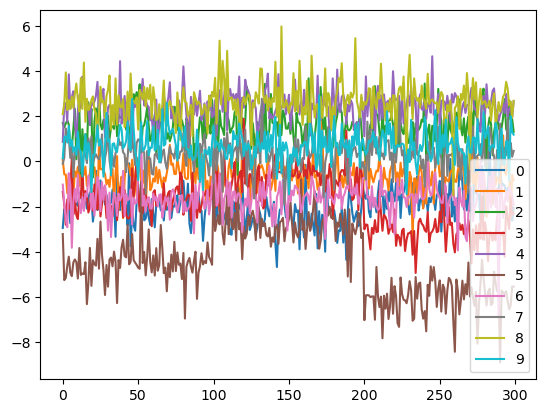

In [83]:
# Base center for the clusters
base_center = list(np.random.uniform(-5, 5, 10))  
n_clusters = 3
n_samples = 300
varying_features = [0, 5, 3]  

# Generate dataset with Laplace distribution (heavy tails)
X, y, centers = make_dynamic_blobs(
    n_samples=n_samples, 
    base_center=base_center, 
    n_clusters=n_clusters, 
    varying_features=varying_features, 
    cluster_std=0.5, 
    center_offset_range=(-2, 2), 
    distribution="laplace",
    random_state=42
)

# Plot the results
fig, ax = plt.subplots()
pd.DataFrame(X).plot(ax=ax, legend=True)
plt.show()


### Exponential

In [133]:
random_states = [2020,2021,2022,2023,2024]#,2021,2022,2023,2024,2025]
n_clusters = 3
n_samples = 1500
varying_features = [0,5,3]

SIGMA = [0.1,0.5,1]

METRICS = []
#METRICS[rs] = {}
RUN_STATS = {}
for sigma in SIGMA:
    RUN_STATS[str(sigma)] = {'F1 & AUC & FP':[],'Covering':[], 'DD':[]}
    for rs in random_states:
        print(rs,sigma)
        #RUN_STATS[sigma] = {}
        X, y, centers = make_dynamic_blobs(
            n_samples=n_samples, 
            base_center=base_center, 
            n_clusters=n_clusters, 
            varying_features=varying_features, 
            cluster_std=sigma, 
            center_offset_range=(-3, 3), 
            random_state=rs, distribution='exponential'
        )
        df, GroundTruth = X, np.where(np.diff(y)!=0)[0]+1
        print(GroundTruth)
        detector = SWDCP(data=df,window_length=50,max_history=50,significance=0.05)
        print(detector.device)
        detector.process_dataloader(p=2,n_theta=5000,explanations=False)
        TMP = {}
        for margin in [5,10,20]:
            TMP[str(margin)] = f_measure({'0':GroundTruth},detector.change_points['loc'],margin=margin)
        RUN_STATS[str(sigma)]['F1 & AUC & FP'].append(TMP)
        RUN_STATS[str(sigma)]['Covering'].append(covering({'0':GroundTruth},detector.change_points['loc'],n_obs=df.shape[0]))
        RUN_STATS[str(sigma)]['DD'].append(detection_delay(GroundTruth,detector.change_points['loc'])[1])
        #print(RUN_STATS)
    #METRICS.append(RUN_STATS)
RUN_STATS


2020 0.1
[ 500 1000]
cpu


 33%|███▎      | 476/1451 [00:03<00:08, 117.38it/s]

Change detected at: 501 
Initiate new segment


 67%|██████▋   | 973/1451 [00:07<00:03, 124.19it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 122.84it/s]


2021 0.1
[ 500 1000]
cpu


 32%|███▏      | 467/1451 [00:03<00:08, 116.96it/s]

Change detected at: 502 
Initiate new segment


 67%|██████▋   | 972/1451 [00:07<00:03, 127.78it/s]

Change detected at: 1002 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 122.16it/s]


2022 0.1
[ 500 1000]
cpu


 33%|███▎      | 474/1451 [00:03<00:07, 123.73it/s]

Change detected at: 501 
Initiate new segment


 67%|██████▋   | 972/1451 [00:07<00:03, 125.37it/s]

Change detected at: 1002 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 122.26it/s]


2023 0.1
[ 500 1000]
cpu


 32%|███▏      | 468/1451 [00:03<00:08, 116.37it/s]

Change detected at: 502 
Initiate new segment


 67%|██████▋   | 975/1451 [00:08<00:03, 119.51it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 118.76it/s]


2024 0.1
[ 500 1000]
cpu


 32%|███▏      | 470/1451 [00:04<00:08, 112.82it/s]

Change detected at: 502 
Initiate new segment


 67%|██████▋   | 970/1451 [00:08<00:03, 124.30it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 120.58it/s]


2020 0.5
[ 500 1000]
cpu


 33%|███▎      | 484/1451 [00:03<00:08, 120.65it/s]

Change detected at: 514 
Initiate new segment


 67%|██████▋   | 970/1451 [00:07<00:03, 120.58it/s]

Change detected at: 1008 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 122.01it/s]


2021 0.5
[ 500 1000]
cpu


 34%|███▍      | 497/1451 [00:04<00:07, 127.59it/s]

Change detected at: 520 
Initiate new segment


 68%|██████▊   | 984/1451 [00:08<00:03, 123.63it/s]

Change detected at: 1017 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 121.78it/s]


2022 0.5
[ 500 1000]
cpu


 33%|███▎      | 473/1451 [00:03<00:08, 121.96it/s]

Change detected at: 509 
Initiate new segment


 68%|██████▊   | 985/1451 [00:08<00:03, 124.58it/s]

Change detected at: 1022 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 122.30it/s]


2023 0.5
[ 500 1000]
cpu


 34%|███▍      | 494/1451 [00:04<00:07, 124.62it/s]

Change detected at: 520 
Initiate new segment


 68%|██████▊   | 985/1451 [00:07<00:03, 126.53it/s]

Change detected at: 1010 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 122.99it/s]


2024 0.5
[ 500 1000]
cpu


 33%|███▎      | 484/1451 [00:04<00:07, 123.66it/s]

Change detected at: 519 
Initiate new segment


 67%|██████▋   | 972/1451 [00:08<00:03, 122.89it/s]

Change detected at: 1009 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 120.10it/s]


2020 1
[ 500 1000]
cpu


 68%|██████▊   | 981/1451 [00:08<00:03, 123.88it/s]

Change detected at: 1018 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 121.76it/s]


2021 1
[ 500 1000]
cpu


100%|██████████| 1451/1451 [00:11<00:00, 124.02it/s]


2022 1
[ 500 1000]
cpu


 34%|███▎      | 489/1451 [00:04<00:07, 126.07it/s]

Change detected at: 521 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 123.20it/s]


2023 1
[ 500 1000]
cpu


 68%|██████▊   | 992/1451 [00:08<00:03, 121.49it/s]

Change detected at: 1022 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 122.55it/s]


2024 1
[ 500 1000]
cpu


 68%|██████▊   | 983/1451 [00:07<00:03, 125.16it/s]

Change detected at: 1022 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 123.01it/s]


{'0.1': {'F1 & AUC & FP': [{'5': (1.0, 1.0, 0),
    '10': (1.0, 1.0, 0),
    '20': (1.0, 1.0, 0)},
   {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)},
   {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)},
   {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)},
   {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)}],
  'Covering': [0.9973373253493014,
   0.9946826029216468,
   0.9960092987994794,
   0.9960093041009613,
   0.9960093041009613],
  'DD': [1.0, 2.0, 1.5, 1.5, 1.5]},
 '0.5': {'F1 & AUC & FP': [{'5': (0.3333333333333333, 0.3333333333333333, 2),
    '10': (0.6666666666666666, 0.6666666666666666, 1),
    '20': (1.0, 1.0, 0)},
   {'5': (0.3333333333333333, 0.3333333333333333, 2),
    '10': (0.3333333333333333, 0.3333333333333333, 2),
    '20': (1.0, 1.0, 0)},
   {'5': (0.3333333333333333, 0.3333333333333333, 2),
    '10': (0.6666666666666666, 0.6666666666666666, 1),
    '20': (0.6666666666666666, 0.6666666666666666, 1)},
   {'5': 

In [134]:
#RUN_STATS['(0.5, 1.0)']['F1 & AUC']
k1,k2,k3 = RUN_STATS.keys()

grouped = {}

for d in RUN_STATS[k1]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

#print(k1,pd.DataFrame(grouped).describe())
for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.round(np.std(v),2))


grouped = {}

for d in RUN_STATS[k2]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key


for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.round(np.std(v),2))


grouped = {}


for d in RUN_STATS[k3]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

#print(k3,pd.DataFrame(grouped).describe())
for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.round(np.std(v),2))

#### 
print("########## Fales Positives ############")

grouped = {}

for d in RUN_STATS[k1]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[2])  # Append the value to the corresponding key

#print(k1,pd.DataFrame(grouped).describe())
for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.min(v),np.max(v))


grouped = {}

for d in RUN_STATS[k2]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[2])  # Append the value to the corresponding key


for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.min(v),np.max(v))


grouped = {}


for d in RUN_STATS[k3]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[2])  # Append the value to the corresponding key

#print(k3,pd.DataFrame(grouped).describe())
for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.min(v),np.max(v))

5 1.0 0.0
10 1.0 0.0
20 1.0 0.0
5 0.33 0.0
10 0.6 0.13
20 0.93 0.13
5 0.47 0.1
10 0.47 0.1
20 0.55 0.17
########## Fales Positives ############
5 0.0 0 0
10 0.0 0 0
20 0.0 0 0
5 2.0 2 2
10 1.2 1 2
20 0.2 0 1
5 0.8 0 1
10 0.8 0 1
20 0.6 0 1


In [135]:
key_dict = list(RUN_STATS.keys())
print('COVERING')
for i in range(3):
    print(key_dict[i],np.mean(RUN_STATS[key_dict[i]]['Covering']),np.std(RUN_STATS[key_dict[i]]['Covering']))
print('DD')
for i in range(3):
    print(key_dict[i],np.mean(RUN_STATS[key_dict[i]]['DD']),np.min(RUN_STATS[key_dict[i]]['DD']),np.max(RUN_STATS[key_dict[i]]['DD']))

COVERING
0.1 0.99600956705447 0.0008394970053005233
0.5 0.9614303222255186 0.006183948515839121
1 0.5843122374430243 0.12550576226919824
DD
0.1 1.5 1.0 2.0
0.5 14.8 11.0 18.5
1 16.6 0.0 22.0




| $\lambda$ | $\tau=5$ | $\tau=10$ | $\tau=20$ |
|-------------|----------|-----------|-----------|
| 0.1       | 1.0 ± 0.0   | 1.0 ± 0.0  | 1 ± 0.23 |
| 0.5        | 0.33 ± 0.0  | 0.6± 0.13  | 0.93± 0.13   |
| 1       | 0.47 ± 0.1 | 0.47 ± 0.1  | 0.55 ± 0.17  |

| $\lambda$| $\tau=5$ | $\tau=10$ | $\tau=20$ |
|-------------|----------|-----------|-----------|
| 0.1        | 0 (0;0)  | 0 (0;0)  | 0 (0;0)|
| 0.5        | 2 (2;2) | 1.2 (1;2) | 0.2  (0;1)  |
| 1      | 0.8 (0;1) | 0.8 (0;1) | 0.6 (0;1) |

## Detection Delay

| jump interval |DD (min;max)|
|-------------|----------|
| 0.1          | 1.5 (1;2) | 
| 0.5        | 14.8 (11;18.5) | 
|  1    | 16.6 (0.0;22) |

### Beta

In [137]:

random_states = [2020,2021,2022,2023,2024]#,2021,2022,2023,2024,2025]
n_clusters = 3
n_samples = 1500
varying_features = [0,5,3]

SIGMA = [0.1,0.5,1]

METRICS = []
#METRICS[rs] = {}
RUN_STATS = {}
for sigma in SIGMA:
    RUN_STATS[str(sigma)] = {'F1 & AUC & FP':[],'Covering':[],'DD':[]}
    for rs in random_states:
        print(rs,sigma)
        #RUN_STATS[sigma] = {}
        X, y, centers = make_dynamic_blobs(
            n_samples=n_samples, 
            base_center=base_center, 
            n_clusters=n_clusters, 
            varying_features=varying_features, 
            cluster_std=sigma, 
            center_offset_range=(-3, 3), 
            random_state=rs, distribution='beta'
        )
        df, GroundTruth = X, np.where(np.diff(y)!=0)[0]+1
        print(GroundTruth)
        detector = SWDCP(data=df,window_length=50,max_history=50,significance=0.05)
        print(detector.device)
        detector.process_dataloader(p=2,n_theta=5000,explanations=False)
        TMP = {}
        for margin in [5,10,20]:
            TMP[str(margin)] = f_measure({'0':GroundTruth},detector.change_points['loc'],margin=margin)
        RUN_STATS[str(sigma)]['F1 & AUC & FP'].append(TMP)
        RUN_STATS[str(sigma)]['Covering'].append(covering({'0':GroundTruth},detector.change_points['loc'],n_obs=df.shape[0]))
        RUN_STATS[str(sigma)]['DD'].append(detection_delay(GroundTruth,detector.change_points['loc'])[1])
        #print(RUN_STATS)
    #METRICS.append(RUN_STATS)
RUN_STATS


2020 0.1
[ 500 1000]
cpu


  0%|          | 0/1451 [00:00<?, ?it/s]

 32%|███▏      | 470/1451 [00:04<00:08, 115.62it/s]

Change detected at: 501 
Initiate new segment


 66%|██████▋   | 962/1451 [00:08<00:04, 121.42it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 115.91it/s]


2021 0.1
[ 500 1000]
cpu


 32%|███▏      | 469/1451 [00:04<00:08, 116.03it/s]

Change detected at: 501 
Initiate new segment


 67%|██████▋   | 968/1451 [00:08<00:04, 118.13it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 119.28it/s]


2022 0.1
[ 500 1000]
cpu


 33%|███▎      | 476/1451 [00:04<00:07, 123.33it/s]

Change detected at: 501 
Initiate new segment


 66%|██████▌   | 961/1451 [00:07<00:04, 121.26it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 120.83it/s]


2023 0.1
[ 500 1000]
cpu


 32%|███▏      | 462/1451 [00:03<00:08, 118.62it/s]

Change detected at: 501 
Initiate new segment


 67%|██████▋   | 975/1451 [00:08<00:04, 112.64it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 119.12it/s]


2024 0.1
[ 500 1000]
cpu


 33%|███▎      | 473/1451 [00:03<00:08, 114.42it/s]

Change detected at: 501 
Initiate new segment


 67%|██████▋   | 969/1451 [00:08<00:03, 122.84it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 118.95it/s]


2020 0.5
[ 500 1000]
cpu


 32%|███▏      | 469/1451 [00:03<00:08, 120.33it/s]

Change detected at: 501 
Initiate new segment


 67%|██████▋   | 972/1451 [00:08<00:03, 122.85it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 119.73it/s]


2021 0.5
[ 500 1000]
cpu


 32%|███▏      | 466/1451 [00:04<00:08, 118.38it/s]

Change detected at: 502 
Initiate new segment


 67%|██████▋   | 973/1451 [00:08<00:03, 120.14it/s]

Change detected at: 1002 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 118.03it/s]


2022 0.5
[ 500 1000]
cpu


 32%|███▏      | 464/1451 [00:03<00:08, 115.19it/s]

Change detected at: 501 
Initiate new segment


 67%|██████▋   | 975/1451 [00:08<00:03, 120.77it/s]

Change detected at: 1002 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 119.59it/s]


2023 0.5
[ 500 1000]
cpu


 32%|███▏      | 467/1451 [00:04<00:08, 117.10it/s]

Change detected at: 502 
Initiate new segment


 66%|██████▋   | 962/1451 [00:08<00:04, 114.96it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 113.34it/s]


2024 0.5
[ 500 1000]
cpu


 32%|███▏      | 469/1451 [00:03<00:08, 119.13it/s]

Change detected at: 502 
Initiate new segment


 67%|██████▋   | 970/1451 [00:08<00:04, 119.26it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 116.74it/s]


2020 1
[ 500 1000]
cpu


 33%|███▎      | 475/1451 [00:03<00:08, 121.96it/s]

Change detected at: 502 
Initiate new segment


 67%|██████▋   | 969/1451 [00:08<00:04, 119.01it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 116.42it/s]


2021 1
[ 500 1000]
cpu


 33%|███▎      | 474/1451 [00:03<00:08, 119.47it/s]

Change detected at: 503 
Initiate new segment


 67%|██████▋   | 965/1451 [00:08<00:03, 121.92it/s]

Change detected at: 1005 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 118.59it/s]


2022 1
[ 500 1000]
cpu


 33%|███▎      | 473/1451 [00:04<00:08, 118.57it/s]

Change detected at: 502 
Initiate new segment


 67%|██████▋   | 967/1451 [00:08<00:04, 116.23it/s]

Change detected at: 1004 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 115.58it/s]


2023 1
[ 500 1000]
cpu


 33%|███▎      | 475/1451 [00:04<00:08, 110.95it/s]

Change detected at: 504 
Initiate new segment


 67%|██████▋   | 972/1451 [00:08<00:04, 115.43it/s]

Change detected at: 1002 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 114.07it/s]


2024 1
[ 500 1000]
cpu


 33%|███▎      | 474/1451 [00:04<00:08, 114.49it/s]

Change detected at: 506 
Initiate new segment


 67%|██████▋   | 965/1451 [00:08<00:04, 119.98it/s]

Change detected at: 1002 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 117.83it/s]


{'0.1': {'F1 & AUC & FP': [{'5': (1.0, 1.0, 0),
    '10': (1.0, 1.0, 0),
    '20': (1.0, 1.0, 0)},
   {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)},
   {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)},
   {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)},
   {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)}],
  'Covering': [0.9973373253493014,
   0.9973373253493014,
   0.9973373253493014,
   0.9973373253493014,
   0.9973373253493014],
  'DD': [1.0, 1.0, 1.0, 1.0, 1.0]},
 '0.5': {'F1 & AUC & FP': [{'5': (1.0, 1.0, 0),
    '10': (1.0, 1.0, 0),
    '20': (1.0, 1.0, 0)},
   {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)},
   {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)},
   {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)},
   {'5': (1.0, 1.0, 0), '10': (1.0, 1.0, 0), '20': (1.0, 1.0, 0)}],
  'Covering': [0.9973373253493014,
   0.9946826029216468,
   0.9960092987994794,
   0.99600930410096

In [138]:
#RUN_STATS['(0.5, 1.0)']['F1 & AUC']


grouped = {}

for d in RUN_STATS[k1]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

#print(k1,pd.DataFrame(grouped).describe())
for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.round(np.std(v),2))


grouped = {}

for d in RUN_STATS[k2]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key


for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.round(np.std(v),2))


grouped = {}


for d in RUN_STATS[k3]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

#print(k3,pd.DataFrame(grouped).describe())
for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.round(np.std(v),2))

#### 
print("########## Fales Positives ############")

grouped = {}

for d in RUN_STATS[k1]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[2])  # Append the value to the corresponding key

#print(k1,pd.DataFrame(grouped).describe())
for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.min(v),np.max(v))


grouped = {}

for d in RUN_STATS[k2]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[2])  # Append the value to the corresponding key


for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.min(v),np.max(v))


grouped = {}


for d in RUN_STATS[k3]['F1 & AUC & FP']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[2])  # Append the value to the corresponding key

#print(k3,pd.DataFrame(grouped).describe())
for k,v in grouped.items():
    print(k,np.round(np.mean(v),2),np.min(v),np.max(v))

5 1.0 0.0
10 1.0 0.0
20 1.0 0.0
5 1.0 0.0
10 1.0 0.0
20 1.0 0.0
5 0.93 0.13
10 1.0 0.0
20 1.0 0.0
########## Fales Positives ############
5 0.0 0 0
10 0.0 0 0
20 0.0 0 0
5 0.0 0 0
10 0.0 0 0
20 0.0 0 0
5 0.2 0 1
10 0.0 0 0
20 0.0 0 0


In [139]:
key_dict = list(RUN_STATS.keys())
print('COVERING')
for i in range(3):
    print(key_dict[i],np.mean(RUN_STATS[key_dict[i]]['Covering']),np.std(RUN_STATS[key_dict[i]]['Covering']))
print('DD')
for i in range(3):
    print(key_dict[i],np.mean(RUN_STATS[key_dict[i]]['DD']),np.min(RUN_STATS[key_dict[i]]['DD']),np.max(RUN_STATS[key_dict[i]]['DD']))

COVERING
0.1 0.9973373253493014 0.0
0.5 0.99600956705447 0.0008394970053005233
1 0.9917767084080953 0.002422707889012768
DD
0.1 1.0 1.0 1.0
0.5 1.5 1.0 2.0
1 3.1 1.5 4.0



| noise | $\tau=5$ | $\tau=10$ | $\tau=20$ |
|-------------|----------|-----------|-----------|
| 0.1       | 1.0 ± 0.0   | 1.0 ± 0.0  | 1 ± 0.0 |
| 0.5       | 1.0 ± 0.0   | 1.0 ± 0.0  | 1 ± 0.0 |
| 1       | 0.93 ± 0.13   | 1.0 ± 0.0  | 1 ± 0.0 |

| noise| $\tau=5$ | $\tau=10$ | $\tau=20$ |
|-------------|----------|-----------|-----------|
| 0.1        | 0 (0;0)  | 0 (0;0)  | 0 (0;0)|
| 0.5        | 0 (0;0)  | 0 (0;0)  | 0 (0;0)|
| 1      |   0.2 (0;1)  | 0 (0;0)  | 0 (0;0)|

## Detection Delay

| noise |DD (min;max)|
|-------------|----------|
| 0.1          | 1.0 (1;1) | 
| 0.5        | 1.5 (1;2) | 
|  1    | 3.1 (1.5;4.0) |

### Laplace

In [84]:

random_states = [2020,2021,2022,2023,2024]#,2021,2022,2023,2024,2025]
n_clusters = 3
n_samples = 1500
varying_features = [0,5,3]

SIGMA = [0.1,0.5,1]

METRICS = []
#METRICS[rs] = {}
RUN_STATS = {}
for sigma in SIGMA:
    RUN_STATS[str(sigma)] = {'F1 & AUC':[],'Covering':[]}
    for rs in random_states:
        print(rs,sigma)
        #RUN_STATS[sigma] = {}
        X, y, centers = make_dynamic_blobs(
            n_samples=n_samples, 
            base_center=base_center, 
            n_clusters=n_clusters, 
            varying_features=varying_features, 
            cluster_std=sigma, 
            center_offset_range=(-3, 3), 
            random_state=rs, distribution='laplace'
        )
        df, GroundTruth = X, np.where(np.diff(y)!=0)[0]+1
        print(GroundTruth)
        detector = SWDCP(data=df,window_length=50,max_history=50,significance=0.05)
        print(detector.device)
        detector.process_dataloader(p=2,n_theta=5000,explanations=False)
        TMP = {}
        for margin in [5,10,20]:
            TMP[str(margin)] = f_measure({'0':GroundTruth},detector.change_points['loc'],margin=margin)
        RUN_STATS[str(sigma)]['F1 & AUC'].append(TMP)
        RUN_STATS[str(sigma)]['Covering'].append(covering({'0':GroundTruth},detector.change_points['loc'],n_obs=df.shape[0]))
        #print(RUN_STATS)
    #METRICS.append(RUN_STATS)
RUN_STATS


2020 0.1
[ 500 1000]
cpu


 33%|███▎      | 474/1451 [00:03<00:07, 130.89it/s]

Change detected at: 501 
Initiate new segment


 67%|██████▋   | 971/1451 [00:07<00:03, 126.78it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 129.94it/s]


2021 0.1
[ 500 1000]
cpu


 32%|███▏      | 466/1451 [00:03<00:08, 115.34it/s]

Change detected at: 501 
Initiate new segment


 67%|██████▋   | 977/1451 [00:07<00:03, 134.04it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 125.01it/s]


2022 0.1
[ 500 1000]
cpu


 32%|███▏      | 468/1451 [00:03<00:08, 117.53it/s]

Change detected at: 501 
Initiate new segment


 66%|██████▋   | 963/1451 [00:08<00:04, 113.31it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 114.39it/s]


2023 0.1
[ 500 1000]
cpu


 32%|███▏      | 470/1451 [00:04<00:08, 114.98it/s]

Change detected at: 501 
Initiate new segment


 67%|██████▋   | 972/1451 [00:08<00:04, 115.97it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 111.77it/s]


2024 0.1
[ 500 1000]
cpu


 32%|███▏      | 462/1451 [00:04<00:09, 104.86it/s]

Change detected at: 501 
Initiate new segment


 66%|██████▋   | 962/1451 [00:08<00:04, 113.76it/s]

Change detected at: 1001 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 112.45it/s]


2020 0.5
[ 500 1000]
cpu


 33%|███▎      | 477/1451 [00:04<00:08, 113.49it/s]

Change detected at: 506 
Initiate new segment


 67%|██████▋   | 970/1451 [00:08<00:04, 104.32it/s]

Change detected at: 1004 
Initiate new segment


100%|██████████| 1451/1451 [00:13<00:00, 111.44it/s]


2021 0.5
[ 500 1000]
cpu


 33%|███▎      | 478/1451 [00:04<00:08, 111.73it/s]

Change detected at: 512 
Initiate new segment


 67%|██████▋   | 972/1451 [00:08<00:04, 96.02it/s] 

Change detected at: 1009 
Initiate new segment


100%|██████████| 1451/1451 [00:13<00:00, 108.65it/s]


2022 0.5
[ 500 1000]
cpu


 33%|███▎      | 478/1451 [00:04<00:08, 114.34it/s]

Change detected at: 506 
Initiate new segment


 67%|██████▋   | 972/1451 [00:08<00:03, 133.80it/s]

Change detected at: 1005 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 124.84it/s]


2023 0.5
[ 500 1000]
cpu


 33%|███▎      | 486/1451 [00:03<00:07, 137.42it/s]

Change detected at: 510 
Initiate new segment


 68%|██████▊   | 981/1451 [00:07<00:03, 142.51it/s]

Change detected at: 1004 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 137.45it/s]


2024 0.5
[ 500 1000]
cpu


 33%|███▎      | 481/1451 [00:03<00:06, 140.59it/s]

Change detected at: 506 
Initiate new segment
Change detected at: 511 
Initiate new segment


 67%|██████▋   | 966/1451 [00:06<00:03, 139.46it/s]

Change detected at: 1005 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 137.66it/s]


2020 1
[ 500 1000]
cpu


 33%|███▎      | 485/1451 [00:03<00:07, 126.45it/s]

Change detected at: 513 
Initiate new segment
Change detected at: 515 
Initiate new segment


 68%|██████▊   | 987/1451 [00:07<00:03, 133.04it/s]

Change detected at: 1011 
Initiate new segment


100%|██████████| 1451/1451 [00:10<00:00, 135.17it/s]


2021 1
[ 500 1000]
cpu


 67%|██████▋   | 977/1451 [00:08<00:04, 114.68it/s]

Change detected at: 1011 
Initiate new segment
Change detected at: 1025 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 119.42it/s]


2022 1
[ 500 1000]
cpu


 33%|███▎      | 484/1451 [00:04<00:08, 114.10it/s]

Change detected at: 513 
Initiate new segment


 67%|██████▋   | 977/1451 [00:08<00:03, 118.99it/s]

Change detected at: 1011 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 114.45it/s]


2023 1
[ 500 1000]
cpu


 33%|███▎      | 481/1451 [00:04<00:08, 116.34it/s]

Change detected at: 520 
Initiate new segment


 67%|██████▋   | 976/1451 [00:08<00:04, 110.21it/s]

Change detected at: 1010 
Initiate new segment


100%|██████████| 1451/1451 [00:12<00:00, 114.18it/s]


2024 1
[ 500 1000]
cpu


 68%|██████▊   | 982/1451 [00:08<00:03, 133.84it/s]

Change detected at: 1013 
Initiate new segment


100%|██████████| 1451/1451 [00:11<00:00, 128.05it/s]


{'0.1': {'F1 & AUC': [{'5': (1.0, 1.0), '10': (1.0, 1.0), '20': (1.0, 1.0)},
   {'5': (1.0, 1.0), '10': (1.0, 1.0), '20': (1.0, 1.0)},
   {'5': (1.0, 1.0), '10': (1.0, 1.0), '20': (1.0, 1.0)},
   {'5': (1.0, 1.0), '10': (1.0, 1.0), '20': (1.0, 1.0)},
   {'5': (1.0, 1.0), '10': (1.0, 1.0), '20': (1.0, 1.0)}],
  'Covering': [0.9973373253493014,
   0.9973373253493014,
   0.9973373253493014,
   0.9973373253493014,
   0.9973373253493014]},
 '0.5': {'F1 & AUC': [{'5': (0.6666666666666666, 0.6666666666666666),
    '10': (1.0, 1.0),
    '20': (1.0, 1.0)},
   {'5': (0.3333333333333333, 0.3333333333333333),
    '10': (0.6666666666666666, 0.6666666666666666),
    '20': (1.0, 1.0)},
   {'5': (0.6666666666666666, 0.6666666666666666),
    '10': (1.0, 1.0),
    '20': (1.0, 1.0)},
   {'5': (0.6666666666666666, 0.6666666666666666),
    '10': (1.0, 1.0),
    '20': (1.0, 1.0)},
   {'5': (0.5714285714285715, 0.5833333333333334),
    '10': (0.8571428571428571, 0.875),
    '20': (0.8571428571428571, 0.875)}

In [85]:
RUN_STATS['0.1']['F1 & AUC']

grouped = {}

for d in RUN_STATS['0.1']['F1 & AUC']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

print(0.1,pd.DataFrame(grouped).describe())


for d in RUN_STATS['0.5']['F1 & AUC']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

print(0.5,pd.DataFrame(grouped).describe())



for d in RUN_STATS['1']['F1 & AUC']:
    for key, value in d.items():
        if key not in grouped:
            grouped[key] = []  # Initialize a list for each key
        grouped[key].append(value[1])  # Append the value to the corresponding key

print(1,pd.DataFrame(grouped).describe())

0.1          5   10   20
count  5.0  5.0  5.0
mean   1.0  1.0  1.0
std    0.0  0.0  0.0
min    1.0  1.0  1.0
25%    1.0  1.0  1.0
50%    1.0  1.0  1.0
75%    1.0  1.0  1.0
max    1.0  1.0  1.0
0.5                5         10         20
count  10.000000  10.000000  10.000000
mean    0.791667   0.954167   0.987500
std     0.239759   0.108387   0.039528
min     0.333333   0.666667   0.875000
25%     0.666667   1.000000   1.000000
50%     0.833333   1.000000   1.000000
75%     1.000000   1.000000   1.000000
max     1.000000   1.000000   1.000000
1                5         10         20
count  15.000000  15.000000  15.000000
mean    0.641667   0.772222   0.950000
std     0.292855   0.291610   0.097336
min     0.291667   0.291667   0.666667
25%     0.333333   0.541667   0.937500
50%     0.666667   1.000000   1.000000
75%     1.000000   1.000000   1.000000
max     1.000000   1.000000   1.000000
